In [175]:
# Importando o dataset de troponina
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Lasso, HuberRegressor, RANSACRegressor, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

<Axes: >

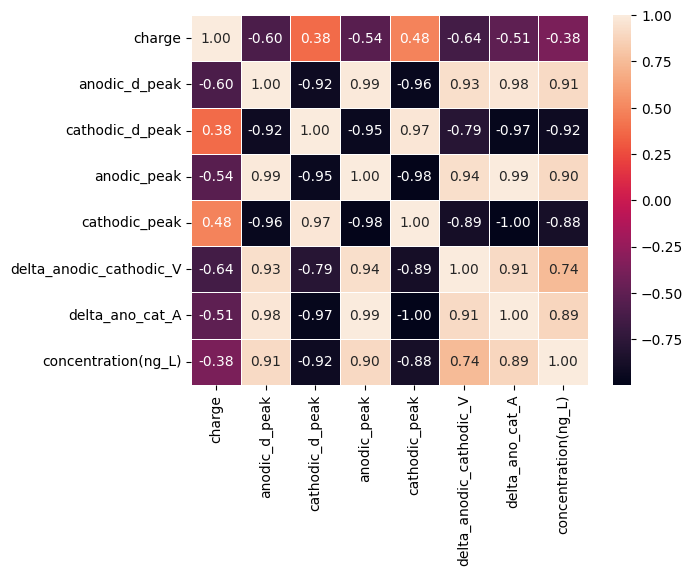

In [162]:
df = pd.read_csv('/home/pedro/Documentos/Workspace/heart_attack_analysis/data/troponin_concentration.csv', index_col=0)
df.head()
correlation = df.corr()
sn.heatmap(correlation, annot=True, fmt='.2f', linewidths=.6)

In [163]:
# Como a carga apresenta baixa correlação, pode-se excluí-la
df_final = df.drop(['charge'], axis=1)

In [164]:
df_final.head()

,anodic_d_peak,cathodic_d_peak,anodic_peak,cathodic_peak,delta_anodic_cathodic_V,delta_ano_cat_A,concentration(ng_L)
0,622.173841,-375.174914,82.78919,-121.886,0.183673,204.67519,600.0
1,635.195364,-268.480580,84.18736,-114.475,0.199645,198.66236,1000.0
2,611.634197,-417.747769,82.22851,-122.168,0.177684,204.39651,1200.0
3,666.173112,-397.214987,90.86034,-128.999,0.215617,219.85934,2000.0
4,638.444389,-413.244030,87.18122,-129.212,0.193656,216.39322,2500.0


In [266]:
# Separando X e Y para regressão
Y = df_final.iloc[:,-1] / 1000
X = df_final[['anodic_d_peak']]

In [267]:
Y.head()

0    0.6
1    1.0
2    1.2
3    2.0
4    2.5
Name: concentration(ng_L), dtype: float64

In [268]:
X.head()

,anodic_d_peak
0,622.173841
1,635.195364
2,611.634197
3,666.173112
4,638.444389


In [269]:
# Padronização dos dados
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X.values, Y.values)

## Regressão Linear

In [270]:
x_train, x_test, y_train, y_test = train_test_split(scaled_X, Y.values, test_size=0.2, random_state=12345)

In [271]:
# Imprimindo o shape de todos os conjuntos já padronizados
print(x_train.shape)
print(x_test.shape)
print(y_train)
print(y_test)

(7, 1)
(2, 1)
[20.   5.   2.5  1.  10.   4.   1.2]
[2.  0.6]


In [272]:
def calculate_coeff_determination(lr, x, y, poly = None):
    if (poly != None):
        features = poly.fit_transform(x)
        r_sq = lr.score(features, y)
    else:
        r_sq = lr.score(x, y)
    return r_sq

In [273]:
lr = LinearRegression()

#Treinando o Modelo
lr.fit(x_train,y_train)
#Verificando o resultado
x_valid = X.values
y_valid = Y.values
scaled_val_x = scaler.transform(x_valid)
r_sq = lr.score(scaled_val_x, y_valid)
print('Coefficient of determination(R²):', r_sq)

Coefficient of determination(R²): 0.8251125755587341


In [274]:
def plot_regression(x, y, regression_model):
    plt.Figure(figsize=(7,7))
    line_x = np.linspace(x.min(), x.max(), 500)
    line_y = lr.predict(scaler.transform(line_x.reshape(-1,1)))
    plt.scatter(x, y)
    plt.plot(line_x, line_y, color = 'r')
    plt.ylabel('[cTnI] in ng.mL⁻1')
    plt.xlabel('Anodic current in uA')
    plt.show()

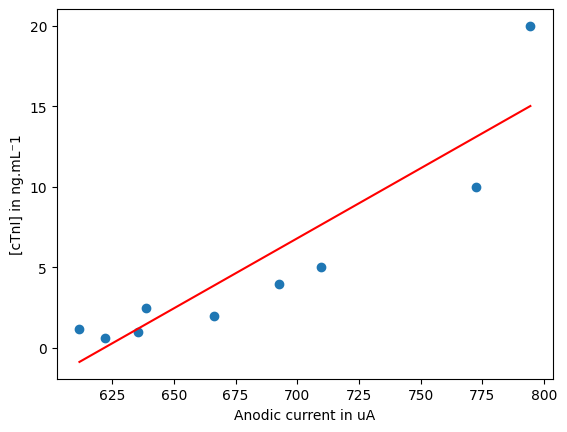

Coefficient of determination(R²): 0.8251125755587341


In [275]:
# Observando a reta da regressão Linear
plt.Figure(figsize=(7,7))
line_x = np.linspace(x_valid.min(), x_valid.max(), 500)
line_y = lr.predict(scaler.transform(line_x.reshape(-1,1)))
plt.scatter(x_valid, y_valid)
plt.plot(line_x, line_y, color = 'r')
plt.ylabel('[cTnI] in ng.mL⁻1')
plt.xlabel('Anodic current in uA')
plt.show()
print('Coefficient of determination(R²):', r_sq)

In [276]:
def get_coefficients(model_regression):
    # Observando os coeficientes
    coeff_df = pd.DataFrame(model_regression.coef_, columns=['Coefficient'])
    coeff_df['Intercept'] = lr.intercept_
    return coeff_df

In [277]:
def get_regression_metrics(model_linear, y_test, x_test, model_poly = None):
    out = {
        'MAE': 0,
        'MSE': 0,
        'RMSE':0
    }
    if (model_poly != None):
        if (x_test.shape[1] > 1):
            x_test = model_poly.fit_transform(x_test)
        else:
           x_test = model_poly.fit_transform(x_test.reshape(-1, 1)) 
        
    y_pred = model_linear.predict(x_test)
    out['MAE'] = metrics.mean_absolute_error(y_test, y_pred)
    out['MSE'] = metrics.mean_squared_error(y_test, y_pred)
    out['RMSE'] = np.sqrt(out['MSE'])
    return out

In [278]:
def print_metrics(metrics:dict):
    for key in metrics.keys():
        print(f'{key}: {metrics[key]}')

In [279]:
_metrics = get_regression_metrics(lr, y_test, x_test)
print_metrics(_metrics)

MAE: 1.2120565330350672
MSE: 1.9028419457458794
RMSE: 1.3794353720801418


In [280]:
# Observando os coeficientes
coeff_df = pd.DataFrame(lr.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
anodic_d_peak,15.8948


In [281]:
# Imprimindo os erros
y_pred = lr.predict(x_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1.2120565330350672
MSE: 1.9028419457458794
RMSE: 1.3794353720801418


In [282]:
x = np.concatenate((x_train, x_test))
y_true = np.concatenate((y_train, y_test))
y_pred = lr.predict(x)
print(x.shape)
print(y_true.shape)
print(y_pred.shape)

(9, 1)
(9,)
(9,)


In [283]:
print(x)

[[1.        ]
 [0.53462   ]
 [0.1465987 ]
 [0.12883296]
 [0.88006083]
 [0.44213151]
 [0.        ]
 [0.29821994]
 [0.057631  ]]


## Polynomial Regression

Polynom Degree 2
Coefficient of determination(R²): 0.9352635574016819
MAE: 0.5766134737306969
MSE: 0.5217915799946519
RMSE: 0.7223514241660024
------------------------------------------


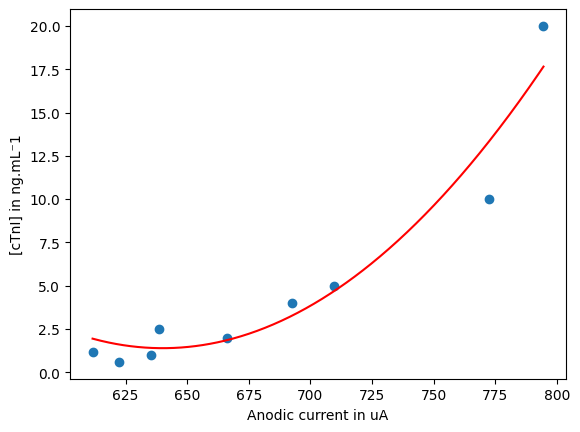

Coefficients
   Coefficient  Intercept
0    -7.084525  -0.869484
1    22.791084  -0.869484
********************
Polynom Degree 3
Coefficient of determination(R²): 0.9623740189652426
MAE: 1.153098254165424
MSE: 1.3957837121529315
RMSE: 1.1814329063272833
------------------------------------------


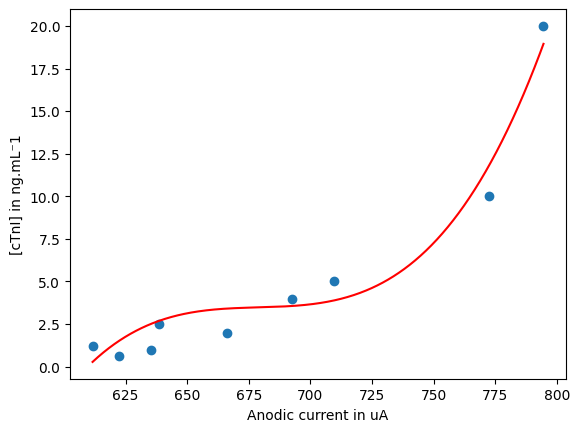

Coefficients
   Coefficient  Intercept
0    24.678610  -0.869484
1   -65.191765  -0.869484
2    59.181585  -0.869484
********************
Polynom Degree 4
Coefficient of determination(R²): 0.9879520720053249
MAE: 1.0156160711315092
MSE: 1.2735292360209833
RMSE: 1.1285075259035642
------------------------------------------


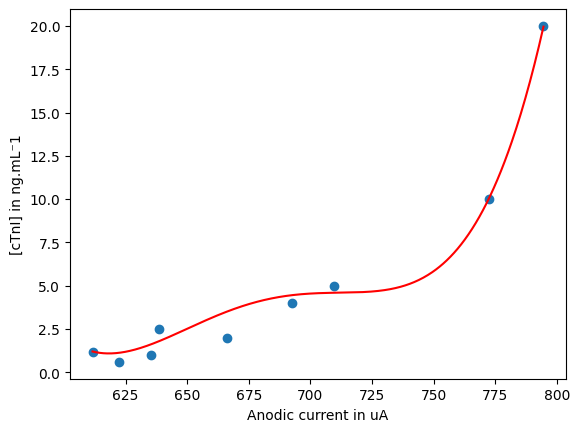

Coefficients
   Coefficient  Intercept
0    -6.464660  -0.869484
1   100.765384  -0.869484
2  -221.941886  -0.869484
3   146.397237  -0.869484
********************
Polynom Degree 5
Coefficient of determination(R²): 0.9924041973209197
MAE: 0.8192514305038889
MSE: 0.6724273245958421
RMSE: 0.8200166611696631
------------------------------------------


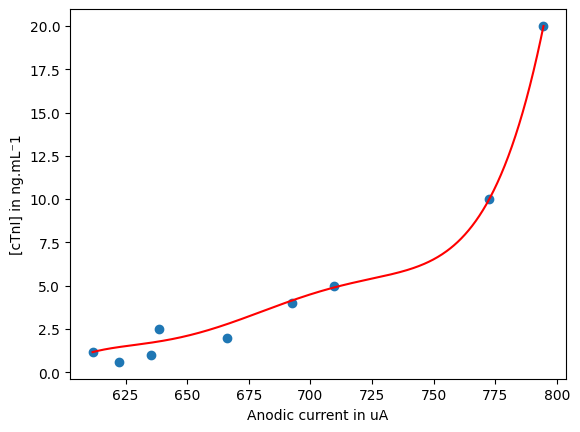

Coefficients
   Coefficient  Intercept
0     6.855291  -0.869484
1   -43.688410  -0.869484
2   224.864050  -0.869484
3  -379.341296  -0.869484
4   210.138840  -0.869484
********************
Polynom Degree 6
Coefficient of determination(R²): 0.8443227493731904
MAE: 4.897844501464524
MSE: 24.586281166214956
RMSE: 4.958455522258413
------------------------------------------


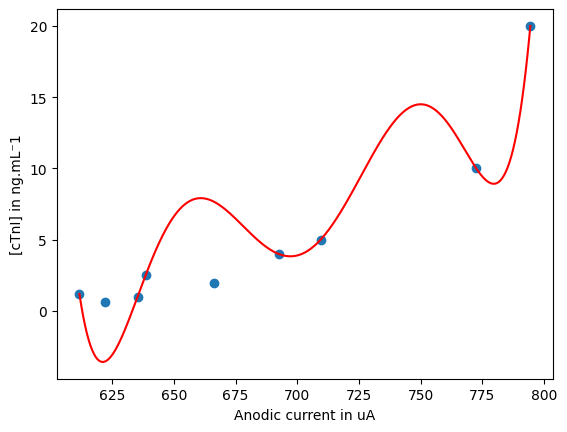

Coefficients
    Coefficient  Intercept
0   -212.535612  -0.869484
1   2932.865287  -0.869484
2 -12983.745980  -0.869484
3  25596.113775  -0.869484
4 -23139.138810  -0.869484
5   7825.241341  -0.869484
********************
Polynom Degree 7
Coefficient of determination(R²): 0.8284230474003184
MAE: 5.0569149109961105
MSE: 27.09733876512617
RMSE: 5.205510423111856
------------------------------------------


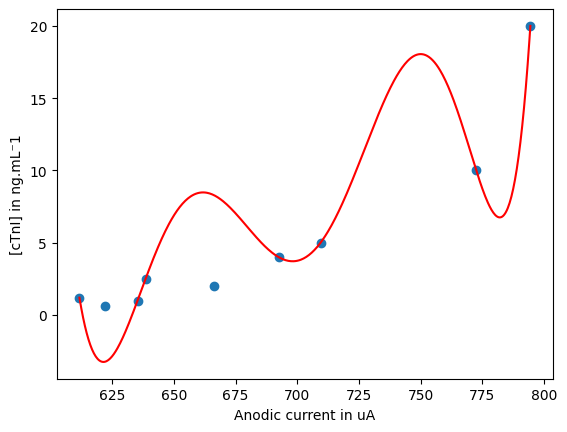

Coefficients
    Coefficient  Intercept
0   -189.602532  -0.869484
1   2454.667571  -0.869484
2  -9347.522416  -0.869484
3  12922.394504  -0.869484
4  -1200.291502  -0.869484
5 -10457.929457  -0.869484
6   5837.083832  -0.869484
********************
Polynom Degree 8
Coefficient of determination(R²): 0.8108482595336548
MAE: 5.223696725966055
MSE: 29.87294454045022
RMSE: 5.465614744971532
------------------------------------------


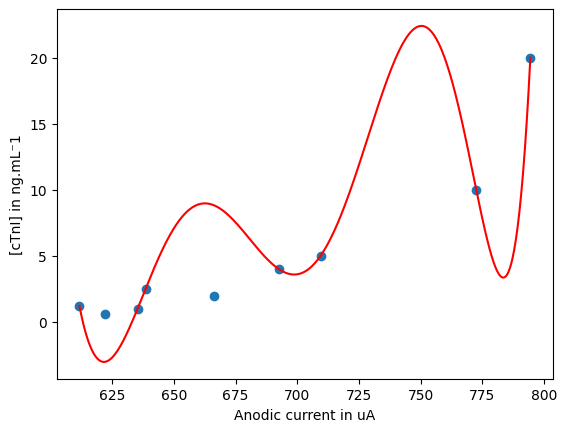

Coefficients
   Coefficient  Intercept
0  -175.007471  -0.869484
1  2168.254749  -0.869484
2 -7407.056898  -0.869484
3  7698.200276  -0.869484
4  2857.856564  -0.869484
5 -4949.089741  -0.869484
6 -4735.878507  -0.869484
7  4561.521029  -0.869484
********************


In [284]:
from sklearn.preprocessing import PolynomialFeatures
degrees = [2, 3, 4, 5, 6, 7, 8]

for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    
    if (x_train.shape[1] > 1):
        poly_features = poly.fit_transform(x_train)
    else:
        poly_features = poly.fit_transform(x_train) 
       
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, y_train)
    mectrics = get_regression_metrics(poly_reg_model, y_test, x_test, poly)
    r_sq = calculate_coeff_determination(poly_reg_model, x, y_true, poly)
    
    print("Polynom Degree", degree)
    print('Coefficient of determination(R²):', r_sq)
    print('MAE:', mectrics['MAE'])
    print('MSE:', mectrics['MSE'])
    print('RMSE:', mectrics['RMSE'])
    print('------------------------------------------')
    
    # Plotando o polinômio
    line_x = np.linspace(x_valid.min(), x_valid.max(), 500).reshape(-1,1)
    line_x = scaler.transform(line_x)
    line_x_features = poly.fit_transform(line_x)
    line_y = poly_reg_model.predict(line_x_features)
    plt.ylabel('[cTnI] in ng.mL⁻1')
    plt.xlabel('Anodic current in uA')
    plt.scatter(x_valid, y_valid)
    plt.plot(scaler.inverse_transform(line_x), line_y, color='r')
    plt.show()
    print("Coefficients")
    print(get_coefficients(poly_reg_model))
    print("*"*20)
    

## Lasso Regression

In [237]:
lasso = Lasso(alpha=0.1)
lasso.fit(x_train, y_train)

Lasso(alpha=0.1)

In [238]:
# Imprimindo os coeficientes
lasso_coeficients = get_coefficients(lasso)
lasso_coeficients

,Coefficient,Intercept
0,15.110337,-0.869484


In [239]:
# Avaliando o modelo
lasso_metrics = get_regression_metrics(lasso, y_test, x_test, None)
print_metrics(lasso_metrics)
r_square = calculate_coeff_determination(lasso, x, y_true, None)
print(f"Coefficient of determination: {r_square}")

MAE: 1.1176899906181306
MSE: 2.006214063805548
RMSE: 1.4164088618070518
Coefficient of determination: 0.8227195441453733


In [240]:
# Avaliando a regressão Lasso polinomial
degrees = [2, 3, 4]

for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    
    if (x_train.shape[1] > 1):
        poly_features = poly.fit_transform(x_train)
    else:
        poly_features = poly.fit_transform(x_train.reshape(-1,1))
    poly_reg_model = Lasso(alpha=0.1)
    poly_reg_model.fit(poly_features, y_train)
    mectrics = get_regression_metrics(poly_reg_model, y_test, x_test, poly)
    r_sq = calculate_coeff_determination(poly_reg_model, x, y_true, poly)
    
    print("Polynom Degree", degree)
    print('Coefficient of determination(R²):', r_sq)
    print('MAE:', mectrics['MAE'])
    print('MSE:', mectrics['MSE'])
    print('RMSE:', mectrics['RMSE'])
    print('------------------------------------------')


Polynom Degree 2
Coefficient of determination(R²): 0.9257912530561866
MAE: 0.5815226776685192
MSE: 0.3395340518598947
RMSE: 0.5826955052683132
------------------------------------------
Polynom Degree 3
Coefficient of determination(R²): 0.9462641915948541
MAE: 0.8178621398192423
MSE: 0.9115199894192361
RMSE: 0.9547355599427708
------------------------------------------
Polynom Degree 4
Coefficient of determination(R²): 0.9573550782885919
MAE: 0.9480050040493448
MSE: 1.0522175619158622
RMSE: 1.0257765652986337
------------------------------------------


# Huber Regressor 

In [241]:
# Avaliando a regressão Lasso polinomial
degrees = [1, 2, 3, 4]

for degree in degrees:
    poly = None
    
    if (degree != 1):
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        
        if (x_train.shape[1] > 1):
            poly_features = poly.fit_transform(x_train)
        else:
           poly_features = poly.fit_transform(x_train.reshape(-1,1))
           
        poly_reg_model = HuberRegressor(alpha=0.001)
        poly_reg_model.fit(poly_features, y_train)
        
    else:
        poly_reg_model = HuberRegressor(alpha=0.001)
        poly_reg_model.fit(x_train, y_train)
        
    mectrics = get_regression_metrics(poly_reg_model, y_test, x_test, poly)
    r_sq = calculate_coeff_determination(poly_reg_model, x, y_true, poly)
    
    print("Polynom Degree", degree)
    print('Coefficient of determination(R²):', r_sq)
    print_metrics(mectrics)
    print('------------------------------------------')

Polynom Degree 1
Coefficient of determination(R²): 0.7522057976283291
MAE: 0.8326122098606032
MSE: 1.1583726842229831
RMSE: 1.0762772339053648
------------------------------------------
Polynom Degree 2
Coefficient of determination(R²): 0.9146584717220343
MAE: 0.33380993706432155
MSE: 0.19570250687167484
RMSE: 0.44238276059502457
------------------------------------------
Polynom Degree 3
Coefficient of determination(R²): 0.9376914805263648
MAE: 1.0650776373084383
MSE: 1.1353829687841253
RMSE: 1.065543508630279
------------------------------------------
Polynom Degree 4
Coefficient of determination(R²): 0.9570629601744659
MAE: 1.256273754585326
MSE: 1.583784725586574
RMSE: 1.2584850915233656
------------------------------------------


## RASNAC Regressor

In [242]:
losses = ['squared_error', 'absolute_error']
for loss in losses:
    print(f"Loss: {loss}")
    print("**"*10)
    for degree in degrees:
        poly = None
        if (degree != 1):
            poly = PolynomialFeatures(degree=degree, include_bias=False)
            if (x_train.shape[1] > 1):
                poly_features = poly.fit_transform(x_train)
            else:
               poly_features = poly.fit_transform(x_train.reshape(-1,1))
               
            poly_reg_model = RANSACRegressor(loss=loss)
            poly_reg_model.fit(poly_features, y_train)
        else:
            poly_reg_model = RANSACRegressor(loss=loss)
            poly_reg_model.fit(x_train, y_train)
        mectrics = get_regression_metrics(poly_reg_model, y_test, x_test, poly)
        r_sq = calculate_coeff_determination(poly_reg_model, x, y_true, poly)
        
        print("Polynom Degree", degree)
        print('Coefficient of determination(R²):', r_sq)
        print_metrics(mectrics)
        print('------------------------------------------')

Loss: squared_error
********************
Polynom Degree 1
Coefficient of determination(R²): 0.6873356292525398
MAE: 0.8908414282965976
MSE: 1.0362084272628227
RMSE: 1.0179432338116023
------------------------------------------
Polynom Degree 2
Coefficient of determination(R²): 0.7987258030162203
MAE: 0.7670527907666318
MSE: 0.5885000353175758
RMSE: 0.7671375595794901
------------------------------------------
Polynom Degree 3
Coefficient of determination(R²): 0.932876939739369
MAE: 0.7379313223385591
MSE: 0.5513720866091781
RMSE: 0.7425443330934377
------------------------------------------
Polynom Degree 4
Coefficient of determination(R²): 0.9879520720053249
MAE: 1.0156160711315092
MSE: 1.2735292360209833
RMSE: 1.1285075259035642
------------------------------------------
Loss: absolute_error
********************
Polynom Degree 1
Coefficient of determination(R²): 0.6873356292525398
MAE: 0.8908414282965976
MSE: 1.0362084272628227
RMSE: 1.0179432338116023
-------------------------------

## SGD Regressor

In [252]:
from sklearn.preprocessing import StandardScaler

param = {
    'loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'alpha': [alpha / 100.0 for alpha in range(1, 11)],
    'epsilon': [epsilon / 100 for epsilon in range(1,11)],
    'learning_rate': ['constant', 'adaptive', 'optimal', 'invscaling']
}

best_param = {
    'loss': None,
    'alpha':None,
    'epsilon': None,
    'learning_rate': None,
    'degree': None
}

min_rmse = np.inf
best_r_square = 0
best_metrics = {}
best_model = None

losses = param['loss']
alphas = param['alpha']
epsilons = param['epsilon']
lrs = param['learning_rate']

scaler = StandardScaler()
new_x = scaler.fit_transform(X.values, Y.values)

n_x_train, n_x_test, n_y_train, n_y_test = train_test_split(new_x, Y, test_size=0.2, random_state=12345)

# print(new_x.shape)

for loss in losses:
    for alpha in alphas:
        for epsilon in epsilons:
            for l in lrs:
                print(f"Loss: {loss}, Apha: {alpha}, Epsilon: {epsilon}, Learning rate: {l}")
                print("**"*10)
                
                for degree in degrees:
                    poly = None
                    
                    if (degree != 1):
                        poly = PolynomialFeatures(degree=degree, include_bias=False)
                        poly_features = poly.fit_transform(n_x_train)
                        poly_reg_model = SGDRegressor(loss=loss, alpha=alpha, learning_rate=l, epsilon=epsilon)
                        poly_reg_model.fit(poly_features, y_train)
                        
                    else:
                        poly_reg_model = SGDRegressor(loss=loss, alpha=alpha, learning_rate=l, epsilon=epsilon)
                        poly_reg_model.fit(n_x_train, y_train)
                        
                    mectrics = get_regression_metrics(poly_reg_model, n_y_test, n_x_test, poly)
                    r_sq = calculate_coeff_determination(poly_reg_model, new_x, Y.values, poly)
                    
                    print("Polynom Degree", degree)
                    print('Coefficient of determination(R²):', r_sq)
                    print_metrics(mectrics)
                    print('------------------------------------------')
                    
                    if (mectrics['RMSE'] < min_rmse):
                        min_rmse = mectrics['RMSE']
                        best_metrics = mectrics
                        best_param['alpha'] = alpha
                        best_param['epsilon'] = epsilon
                        best_param['learning_rate'] = l
                        best_param['loss'] = loss
                        best_param['degree'] = degree
                        best_r_square = r_sq
                        best_model = poly_reg_model
                                        
print(f'Best R²: {best_r_square}')
print_metrics(best_metrics)
print(best_param)

Loss: squared_error, Apha: 0.01, Epsilon: 0.01, Learning rate: constant
********************
Polynom Degree 1
Coefficient of determination(R²): 0.8251776448733437
MAE: 1.180256754750739
MSE: 1.8517109000298395
RMSE: 1.360775844887702
------------------------------------------
Polynom Degree 2
Coefficient of determination(R²): 0.9326891095764792
MAE: 0.7704193670825883
MSE: 0.7470877958646691
RMSE: 0.864342406610175
------------------------------------------
Polynom Degree 3
Coefficient of determination(R²): 0.963790794113532
MAE: 0.9847640040327301
MSE: 0.970184310408087
RMSE: 0.9849793451682562
------------------------------------------
Polynom Degree 4
Coefficient of determination(R²): 0.9866116022492302
MAE: 1.0296083342698554
MSE: 1.1790339160100913
RMSE: 1.0858332818670144
------------------------------------------
Loss: squared_error, Apha: 0.01, Epsilon: 0.01, Learning rate: adaptive
********************
Polynom Degree 1
Coefficient of determination(R²): 0.8251382407573804
MAE: 

In [253]:
best_coefficients = get_coefficients(best_model)
best_coefficients

,Coefficient,Intercept
0,3.676479,-0.869484
1,1.297749,-0.869484


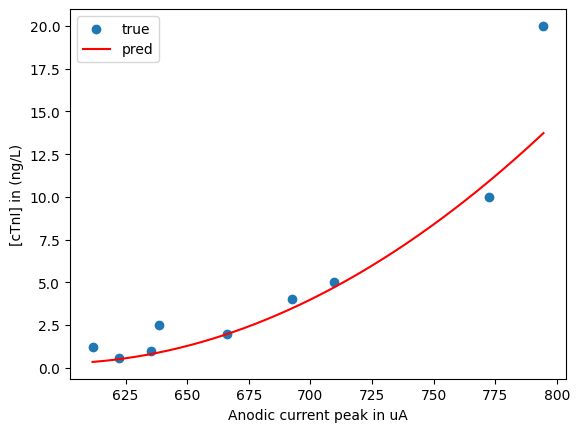

In [254]:
# Plotando para verificar o modelo
import matplotlib.pyplot as plt
plt.Figure()
plt.scatter(scaler.inverse_transform(new_x), Y, label = 'true')
x_values = np.linspace(X.min(), X.max(), 500)
new_x_values = scaler.transform(x_values)
poly = PolynomialFeatures(degree=best_param['degree'], include_bias=False)
poly_features = poly.fit_transform(new_x_values.reshape(-1, 1))
pred = best_model.predict(poly_features)
plt.plot(scaler.inverse_transform(new_x_values), pred, color='red', label = 'pred')
plt.ylabel('[cTnI] in (ng/L)')
plt.xlabel('Anodic current peak in uA')
plt.legend()
plt.show()


## Utilizando o Support Vector Regression

In [257]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


param = {
    'kernel': ['poly', 'linear', 'rbf', 'sigmoid'],
    'C': [c for c in range(1,11)],
    'degree': [1, 2, 3, 4]
}

# Separando X e Y para regressão
Y = df_final.iloc[:,-1].values / 1000
X = df_final.values

scaled_x = scaler.fit_transform(X, Y)
x_train, x_test, y_train, y_test = train_test_split(scaled_x, Y, random_state=12345)

base_regressor = SVR()
clf = GridSearchCV(base_regressor, param)
clf.fit(x_train, y_train)
print(clf.best_estimator_)
mae = metrics.mean_absolute_error(y_test, clf.best_estimator_.predict(x_test))
msr = metrics.mean_squared_error(y_test, clf.best_estimator_.predict(x_test))

print(mae)
print(msr)
print(np.sqrt(msr))
print(clf.best_estimator_.score(scaled_x, Y))
# if (n_x_train.shape[1] > 1):
#     n_y_train = StandardScaler().fit_transform(n_x_train)
# else:
#     n_y_train = StandardScaler().fit_transform(n_x_train.reshape(-1,1))

# base_regressor.fit(n_x_train, n_y_train)
# print(f"Best Parameters: {base_regressor.get_params()}" )
# results = get_regression_metrics(base_regressor, n_y_test, n_x_test)
# print_metrics(results)

SVR(C=1, degree=1, kernel='poly')
4.4288256146252465
48.19342084953285
6.9421481437328065
0.4999775191037047


# Desision Tree regressor

In [263]:
from sklearn.tree import DecisionTreeRegressor
param = {
    'criterion': ['squared_error', 'firedman_mse', 'absolute_error', 'poisson']
}

decision_tree = DecisionTreeRegressor(random_state=12345)
clf = GridSearchCV(decision_tree, param, cv=2)
clf.fit(x_train, y_train)
print(clf.best_estimator_)
mae = metrics.mean_absolute_error(y_test, clf.best_estimator_.predict(x_test))
msr = metrics.mean_squared_error(y_test, clf.best_estimator_.predict(x_test))

print(mae)
print(msr)
print(np.sqrt(msr))
print(clf.best_estimator_.score(scaled_x, Y))
print(clf.best_estimator_.get_params())


DecisionTreeRegressor(random_state=12345)
3.6333333333333333
33.47
5.785326265648291
0.6821082328441375
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 12345, 'splitter': 'best'}


# KNN - Regressor


In [264]:
from sklearn.neighbors import KNeighborsRegressor
param = {
    'n_neighbors': [2, 3],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['minkowski', 'euclidian']
}

knn_r = KNeighborsRegressor()
base_regressor = SVR()
clf = GridSearchCV(knn_r, param, refit = True, verbose = 3,n_jobs=-1, cv=2)
clf.fit(x_train, y_train)
print(clf.best_params_)
mae = metrics.mean_absolute_error(y_test, clf.best_estimator_.predict(x_test))
msr = metrics.mean_squared_error(y_test, clf.best_estimator_.predict(x_test))

print(mae)
print(msr)
print(np.sqrt(msr))
print(clf.best_estimator_.score(scaled_x, Y))
print(clf.best_estimator_.get_params())

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV 2/2] END algorithm=auto, metric=minkowski, n_neighbors=2, weights=uniform;, score=0.025 total time=   0.0s[CV 1/2] END algorithm=auto, metric=minkowski, n_neighbors=2, weights=uniform;, score=0.196 total time=   0.0s

[CV 2/2] END algorithm=auto, metric=minkowski, n_neighbors=2, weights=distance;, score=0.188 total time=   0.0s
[CV 1/2] END algorithm=auto, metric=minkowski, n_neighbors=2, weights=distance;, score=0.751 total time=   0.0s
[CV 1/2] END algorithm=auto, metric=minkowski, n_neighbors=3, weights=uniform;, score=-1.832 total time=   0.0s
[CV 2/2] END algorithm=auto, metric=minkowski, n_neighbors=3, weights=uniform;, score=-0.370 total time=   0.0s
[CV 1/2] END algorithm=auto, metric=euclidian, n_neighbors=2, weights=uniform;, score=nan total time=   0.0s
[CV 1/2] END algorithm=auto, metric=euclidian, n_neighbors=2, weights=distance;, score=nan total time=   0.0s
[CV 1/2] END algorithm=auto, metric=minkowski, n_n